In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import svm_classifier
import debias
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier

import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['agg.path.chunksize'] = 10000

In [2]:
def tsne_by_gender(vecs, labels, title):

  tsne = TSNE(n_components=2, random_state=0)
  vecs_2d = tsne.fit_transform(vecs)

  names = ["class 1", "class 2"]
  plt.figure(figsize=(6, 5))
  colors = 'r', 'b'
  for i, c, label in zip(range(10), colors, names):
    plt.scatter(vecs_2d[labels == i, 0], vecs_2d[labels == i, 1], c=c, label=label, alpha = 0.2)
  plt.legend()
  plt.title(title)
  plt.show()
  return vecs_2d

### Data loading & processing

In [3]:
def load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt"):
    
    model = KeyedVectors.load_word2vec_format(fname, binary=False)
    vecs = model.vectors
    words = list(model.vocab.keys())
    return model, vecs, words

def project_on_gender_subspaces(gender_vector, model: Word2VecKeyedVectors):
    
    group1 = model.similar_by_vector(gender_vector, topn = 3000, restrict_vocab=None)
    group2 = model.similar_by_vector(-gender_vector, topn = 3000, restrict_vocab=None)
    
    return group1, group2

def get_vectors(word_list: list, model: Word2VecKeyedVectors):
    
    vecs = []
    for w in word_list:
        
        vecs.append(model[w])
    
    vecs = np.array(vecs)
    return vecs

In [4]:
model, vecs, words = load_word_vectors(fname = "../data/embeddings/vecs.filtered.txt")
model_gendered, _, _ = load_word_vectors(fname = "../data/embeddings/vecs.gendered.txt")
#gender_direction = model_gendered["man"] - model_gendered["woman"]
gender_direction = model_gendered["he"] - model_gendered["she"]

masc_words_and_scores, fem_words_and_scores = project_on_gender_subspaces(gender_direction, model)
masc_words, masc_scores = list(zip(*masc_words_and_scores))
fem_words, fem_scores = list(zip(*fem_words_and_scores))

masc_vecs, fem_vecs = get_vectors(masc_words, model), get_vectors(fem_words, model)

print(masc_words[:10])
print(masc_words[-10:])
print("-------------------------")
print(fem_words[:10])
print(fem_words[-10:])

('journeyman', 'elder_statesman', 'fellow_countryman', 'endeared_himself', 'cult_hero', 'journeymen', 'swashbuckling', 'distanced_himself', 'prodigal_son', 'tradeable')
('audio', 'twice', 'testicles', 'silenced', 'luring', 'appeasing', 'career_multihomer', 'groin_muscle', 'archenemy', 'contemporaries')
-------------------------
('alumna', 'beautician', 'motherly', 'petite', 'comedienne', 'saleswoman', 'songstress', 'ditzy', 'mommies', 'lip_gloss')
('cloths', 'cooks', 'prosthesis', 'pneumatic', 'disability', 'melons', 'lunches', 'goody', 'doctoral_student', 'mattress')


### Perform train-dev-test split

In [6]:
X = np.concatenate((masc_vecs, fem_vecs), axis = 0)
y_masc = np.zeros(masc_vecs.shape[0], dtype = int)
y_fem = np.ones(fem_vecs.shape[0], dtype = int)
y = np.concatenate((y_masc, y_fem))
X_train_dev, X_test, y_train_dev, y_test = sklearn.model_selection.train_test_split(X, y, test_size = 0.4, random_state = 0)
X_train, X_dev, Y_train, Y_dev = sklearn.model_selection.train_test_split(X_train_dev, y_train_dev, test_size = 0.3, random_state = 0)
print("Train size: {}; Dev size: {}; Test size: {}".format(X_train.shape[0], X_dev.shape[0], X_test.shape[0]))

Train size: 2520; Dev size: 1080; Test size: 2400


### Debias

In [15]:
classifier_class = svm_classifier.SVMClassifier
num_classifiers = 50
input_dim = 300
is_autoregressive = True
min_accuracy = 0.49
add_noise = True

P = debias.get_debiasing_projection(classifier_class, num_classifiers, input_dim, 
                                    is_autoregressive, min_accuracy, X_train, Y_train,
                                    X_dev, Y_dev, add_noise)

Adding noise.


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 0, Accuracy: 0.9842592592592593


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 1, Accuracy: 0.962037037037037
Iteration 2, Accuracy: 0.9111111111111111
Iteration 3, Accuracy: 0.8351851851851851


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 4, Accuracy: 0.7444444444444445
Iteration 5, Accuracy: 0.7620370370370371
Iteration 6, Accuracy: 0.7


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 7, Accuracy: 0.5592592592592592


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 8, Accuracy: 0.5685185185185185


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 9, Accuracy: 0.5564814814814815


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 10, Accuracy: 0.5574074074074075


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 11, Accuracy: 0.5592592592592592
Iteration 12, Accuracy: 0.6027777777777777
Iteration 13, Accuracy: 0.5898148148148148


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 14, Accuracy: 0.5268518518518519


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 15, Accuracy: 0.48333333333333334


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 16, Accuracy: 0.5314814814814814
Iteration 17, Accuracy: 0.5509259259259259


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 18, Accuracy: 0.5101851851851852


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 19, Accuracy: 0.5074074074074074


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 20, Accuracy: 0.5064814814814815
Iteration 21, Accuracy: 0.525


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 22, Accuracy: 0.49166666666666664
Iteration 23, Accuracy: 0.5


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 24, Accuracy: 0.5
Iteration 25, Accuracy: 0.5101851851851852


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 26, Accuracy: 0.49166666666666664


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 27, Accuracy: 0.48703703703703705
Iteration 28, Accuracy: 0.5064814814814815


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 29, Accuracy: 0.5453703703703704


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 30, Accuracy: 0.4722222222222222
Iteration 31, Accuracy: 0.5166666666666667


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 32, Accuracy: 0.5027777777777778
Iteration 33, Accuracy: 0.5111111111111111


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 34, Accuracy: 0.4981481481481482
Iteration 35, Accuracy: 0.5166666666666667
Iteration 36, Accuracy: 0.5231481481481481


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 37, Accuracy: 0.5268518518518519


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 38, Accuracy: 0.49722222222222223


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 39, Accuracy: 0.5157407407407407


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 40, Accuracy: 0.537962962962963
Iteration 41, Accuracy: 0.525


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 42, Accuracy: 0.49074074074074076
Iteration 43, Accuracy: 0.525


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 44, Accuracy: 0.4703703703703704


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 45, Accuracy: 0.5157407407407407
Iteration 46, Accuracy: 0.5305555555555556


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 47, Accuracy: 0.47129629629629627
Iteration 48, Accuracy: 0.537962962962963


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Iteration 49, Accuracy: 0.4777777777777778


### Test the quality of the debiasing.

#### Perform t-sne

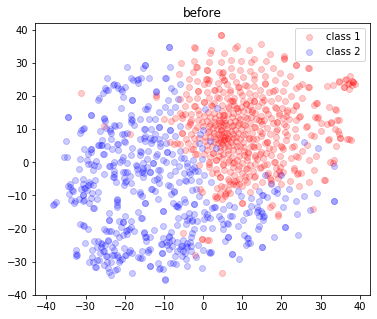

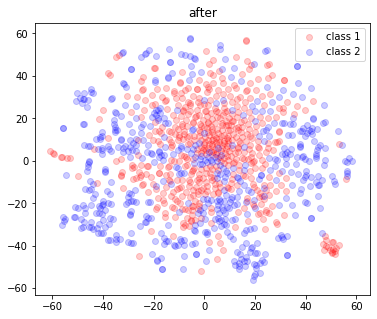

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/metrics/pairwise.py:258: RuntimeWarning: invalid value encountered in sqrt

Purity in original space: 0.8068166361244357
Purity after tsne projection: 0.40013068494230214


In [17]:
def perform_purity_test(vecs, k, labels_true):
        np.random.seed(0)
        clustering = sklearn.cluster.KMeans(n_clusters = k)
        clustering.fit(vecs)
        labels_pred = clustering.labels_
        score = sklearn.metrics.homogeneity_score(labels_true, labels_pred)
        return score


tsne_by_gender(X_dev, Y_dev, title = "before")
X_dev_cleaned = X_dev.dot(P)
X_test_cleaned = X_test.dot(P)
X_trained_cleaned = X_train.dot(P)
tsne_projection = tsne_by_gender(X_dev_cleaned, Y_dev, title = "after")

NUM_CLUSTERS = 100

purity_original = perform_purity_test(X_dev, k = NUM_CLUSTERS, labels_true = Y_dev)
purity_after = perform_purity_test(X_dev_cleaned, k = NUM_CLUSTERS, labels_true = Y_dev)
print("Purity in original space: {}".format(purity_original))
print("Purity after tsne projection: {}".format(purity_after))

#### Train a nonlinear classifier for gender prediction.

In [19]:
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")
#nonlinear_clf = SGDClassifier(loss = "modified_huber", verbose = 0, max_iter = 5000, fit_intercept = True, class_weight = "balanced", penalty = "l2")
print("Before:")
nonlinear_clf.fit(X_train, Y_train)
print(nonlinear_clf.score(X_dev, Y_dev))

print("After:")
nonlinear_clf = MLPClassifier(hidden_layer_sizes = 128, activation = "relu")
nonlinear_clf = SVC(kernel = "rbf")

nonlinear_clf.fit(X_trained_cleaned, Y_train)
print(nonlinear_clf.score(X_dev_cleaned, Y_dev))

Before:


/home/shauli/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


1.0
After:
0.9592592592592593


#### project on the gender direction

In [26]:
bias_after = ((X_dev_cleaned/(np.linalg.norm(X_dev_cleaned))).dot(gender_direction/np.linalg.norm(gender_direction)))
np.mean(bias_after)

0.0001738185441809328

#### calculate the similarity matrix before and after

In [23]:

def get_similarity_matrix(vecs: np.ndarray):

  vecs_normalized = vecs / np.linalg.norm(vecs, axis = 1, keepdims = True)
  distances = vecs_normalized.dot(vecs_normalized.T)
  minx = -1 
  maxx = 1
  distances = (distances - minx) / (maxx-minx)
  #distances = sklearn.metrics.pairwise_distances(vecs_normalized, vecs_normalized, metric="cosine")
  
  return distances

def plot_similarity(similarity_before, similarity_after):

    idx = similarity_before > 0.5 # we are only interested in the relatively close words

    similarity_before = similarity_before[idx]
    similarity_after = similarity_after[idx]
    
    chosen = np.random.rand(len(similarity_after)) < 0.01
    before = similarity_before[chosen]
    after = similarity_after[chosen]
    print(len(before), len(after))
    plt.plot(before, after, linestyle="None", marker = "*", alpha = 0.1)
    plt.xlabel("similarity before")
    plt.ylabel("similarity after")

    plt.show()
    print("Correlation: {}".format(pearsonr(before, after)[0]))

(2534,) (6421156,)
52685 52685


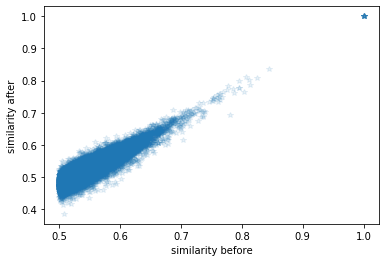

Correlation: 0.9015601944983672


In [34]:
prop = 0.05
idx = np.random.rand(vecs.shape[0]) < prop
vecs_sample = vecs[idx]
vecs_sample_cleaned = vecs_sample.dot(P)

similarity_before = get_similarity_matrix(vecs_sample).reshape(-1)
similarity_after = get_similarity_matrix(vecs_sample_cleaned).reshape(-1)
diffs = abs(similarity_before - similarity_after)


gender_unit_vec = gender_direction/np.linalg.norm(gender_direction)
sample_normalized = vecs_sample/np.linalg.norm(vecs_sample, axis = 1, keepdims = True)
sample_cleaned_normalized = vecs_sample_cleaned/np.linalg.norm(vecs_sample_cleaned, axis = 1, keepdims = True)

bias_before = sample_normalized.dot(gender_unit_vec)
bias_after = sample_cleaned_normalized.dot(gender_unit_vec)
print(bias_before.shape, diffs.shape)

plot_similarity(similarity_before, similarity_after)